In [259]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize 
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [253]:
# from inversions_1d import create_inversion, run_inv

In [254]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

# load data 

In [375]:
n_times_invert = 20

In [376]:
rx_locs = np.load("rx_locs.npy")

In [377]:
def load_pre_file(filepath):
    """
    Load a GIF-style .pre file (TDoctree format).

    Parameters
    ----------
    filepath : str
        Path to the .pre-style data file

    Returns
    -------
    dict
        {
            "ignore": float or None,
            "n_trx": int,
            "transmitters": list of {
                "location": list of float,
                "n_recv": int,
                "n_time": int,
                "receivers": list of {
                    "loc": (x, y, z),
                    "time": float,
                    "data": list of float
                }
            }
        }
    """
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    ignore_value = None
    transmitters = []

    # Parse IGNORE line if present
    if lines[i].startswith("IGNORE"):
        ignore_value = float(lines[i].split()[1])
        i += 1

    # Parse number of transmitters
    if lines[i].startswith("N_TRX"):
        n_trx = int(lines[i].split()[1])
        i += 1
    else:
        raise ValueError("Missing N_TRX line")

    while i < len(lines):
        if lines[i].startswith("TRX_LOOP"):
            i += 1
            location = list(map(float, lines[i].split()))
            i += 1
            if not lines[i].startswith("N_RECV"):
                raise ValueError("Expected N_RECV")
            n_recv = int(lines[i].split()[1])
            i += 1
            if not lines[i].startswith("N_TIME"):
                raise ValueError("Expected N_TIME")
            n_time = int(lines[i].split()[1])
            i += 1

            receivers = []
            for _ in range(n_recv * n_time):
                parts = lines[i].split()
                x, y, z = map(float, parts[0:3])
                time = float(parts[3])
                data = list(map(float, parts[4:]))
                receivers.append({
                    "loc": (x, y, z),
                    "time": time,
                    "data": data
                })
                i += 1

            transmitters.append({
                "location": location,
                "n_recv": n_recv,
                "n_time": n_time,
                "receivers": receivers
            })
        else:
            i += 1  # Skip unknown or empty lines

    return {
        "ignore": ignore_value,
        "n_trx": len(transmitters),
        "transmitters": transmitters
    }


In [378]:
dobs = load_pre_file("dobs.txt")

In [379]:
rx_times = np.array([dobs["transmitters"][0]["receivers"][j]["time"] for j in range(len(dobs["transmitters"][0]["receivers"]))])

In [380]:
rx_times

array([2.00000000e-05, 2.54854997e-05, 3.24755348e-05, 4.13827616e-05,
       5.27330180e-05, 6.71963657e-05, 8.56266480e-05, 1.09111896e-04,
       1.39038559e-04, 1.77173358e-04, 2.25767578e-04, 2.87689978e-04,
       3.66596142e-04, 4.67144294e-04, 5.95270288e-04, 7.58538038e-04,
       9.66586048e-04, 1.23169642e-03, 1.56951994e-03, 2.00000000e-03])

In [381]:
n_times_invert = len(rx_times)

# create survey

In [382]:
tx_height = rx_locs[0, 2]
source_list = []

for i in range(rx_locs.shape[0]): 
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
    src = tdem.sources.CircularLoop(
        receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

full_survey = tdem.Survey(source_list)


In [383]:
dobs_values = np.zeros((n_times_invert, len(dobs["transmitters"])))
for i in range(len(dobs["transmitters"])): 
    for j in range(n_times_invert): 
        dobs_values[j, i] = dobs["transmitters"][i]["receivers"][j]["data"][-2]

In [384]:
observed_data = Data(survey=full_survey, dobs=-discretize.utils.mkvc(dobs_values))

In [385]:
ind = 25
rx_locs[ind, :]

array([-50.,   0.,  30.])

In [386]:
ubc_mesh = discretize.TreeMesh.read_UBC("octree_mesh.txt")
model = discretize.TreeMesh.read_model_UBC(ubc_mesh, "target_45.con")

In [387]:
len(full_survey.source_list)

61

In [388]:
src_ind = int((len(full_survey.source_list) -1 )/2)
src_ind

30

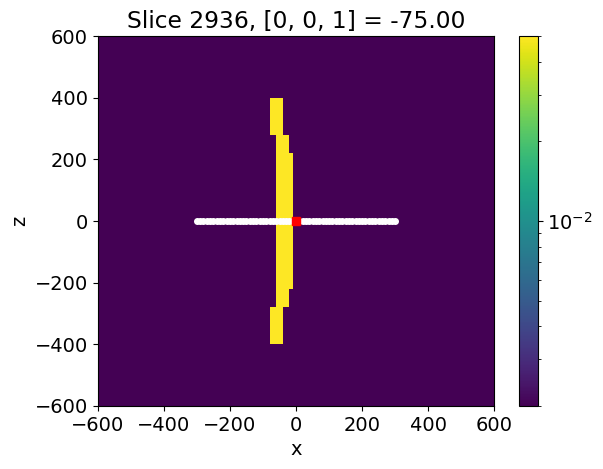

In [389]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax, pcolor_opts={"norm":LogNorm()}, 
        normal="Z", ind=2936
    )[0], 
    ax=ax
)

ax.set_xlim(600*np.r_[-1, 1])
ax.set_ylim(600*np.r_[-1, 1])

ax.plot(rx_locs[:, 0], rx_locs[:, 1], "wo", ms=4)
ax.plot(rx_locs[src_ind, 0], rx_locs[src_ind, 1], "rs", ms=6)

In [390]:
observed_data[src, src.receiver_list[0]]

array([-1.362393e-07, -7.769214e-08, -4.261609e-08, -2.472693e-08,
       -1.437281e-08, -8.426611e-09, -5.057715e-09, -3.109436e-09,
       -1.889570e-09, -1.197388e-09, -7.342340e-10, -4.326695e-10,
       -2.442832e-10, -1.286965e-10, -6.951879e-11, -3.634966e-11,
       -1.869063e-11, -9.460995e-12, -5.134165e-12, -2.749332e-12])

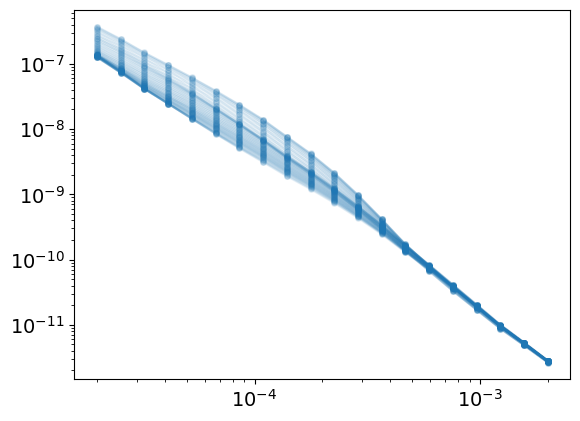

In [391]:
for src_ind in range(len(rx_locs)): 
    src = full_survey.source_list[src_ind]
    
    # plt.loglog(rx_times, -data_dict["background"][src, src.receiver_list[0]], "k", alpha=0.5)
    plt.loglog(rx_times, -observed_data[src, src.receiver_list[0]], "C0-o", ms=4, alpha=0.1)

In [392]:
# target_z_center = -60
# target_thickness = 40

thicknesses_true = np.r_[40, 40]
sigma_true = 1./np.r_[500, 20, 500]

In [393]:
src_ind = int(len(rx_locs)/2)
src_ind

30

In [394]:

source_sounding = full_survey.source_list[src_ind]
survey_sounding = tdem.Survey([source_sounding])
sim1d_true = tdem.Simulation1DLayered(
    survey=survey_sounding, thicknesses=thicknesses_true, sigmaMap=maps.IdentityMap(nP=3)
)

In [395]:
dpred_halfspace = sim1d_true.dpred(1./500*np.ones(3))

In [396]:
dpred_1d = sim1d_true.dpred(sigma_true)

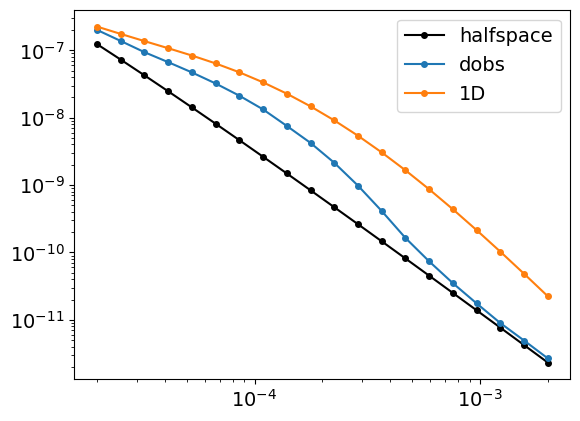

In [397]:
fig, ax = plt.subplots(1, 1)

ax.loglog(rx_times, -dpred_halfspace, "k-o", ms=4, label="halfspace")
ax.loglog(rx_times, -observed_data[source_sounding, source_sounding.receiver_list[0]], "C0-o", ms=4, label="dobs")
ax.loglog(rx_times, -dpred_1d, "C1-o", ms=4, label="1D")

ax.legend()

In [398]:
# octree_mesh = discretize.load_mesh("./synthetic-data/treemesh.json")

# octree_mesh = discretize.load_mesh()

In [399]:
cs = 10
core_region = 200
npad = 12
padding_factor = 1.3

thicknesses1d = discretize.utils.unpack_widths(
    [(cs, np.int64(np.ceil(core_region/cs))), (cs, npad, padding_factor)]
)

In [400]:
np.sum(thicknesses1d)


np.float64(1166.2503553075103)

In [437]:
# set up 1D inversion 
def create_inversion(
    ind,
    dobs,
    rx_times_invert=rx_times[:n_times_invert],
    rx_locs=rx_locs, 
    relative_error=0.05,
    noise_floor=1e-13,
    alpha_s = 1e-1,
    alpha_x = 1,
    rho_back = 500,
    beta0 = 200,
): 
    cs = 10
    core_region = 200
    npad = 12
    padding_factor = 1.3
    
    thicknesses1d = discretize.utils.unpack_widths(
        [(cs, np.int64(np.ceil(core_region/cs))), (cs, npad, padding_factor)]
    )
    
    rx_sounding = tdem.receivers.PointMagneticFluxTimeDerivative(
        locations=rx_locs[ind, :], times=rx_times_invert, orientation="z"
    )
    src_sounding = tdem.sources.CircularLoop(
        receiver_list=[rx_sounding], location=rx_locs[ind, :], orientation="z", 
        radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    survey_sounding = tdem.Survey([src_sounding])
    mesh_invert = discretize.TensorMesh([(np.r_[thicknesses1d, thicknesses1d[-1]])], origin="0")
    
    sim1d = tdem.Simulation1DLayered(
        survey=survey_sounding, thicknesses=thicknesses1d, sigmaMap=maps.ExpMap(mesh_invert)
    )

    data_invert = Data(
        survey_sounding, 
        dobs=dobs,
        standard_deviation=relative_error*np.abs(dobs) + noise_floor
    )
    
    dmis = data_misfit.L2DataMisfit(simulation=sim1d, data=data_invert)
    reg = regularization.WeightedLeastSquares(
        mesh_invert, alpha_s=alpha_s, alpha_x=alpha_x, 
        # reference_model=np.log(1./rho_back),
        # norms=norms
    )
    
    opt = optimization.InexactGaussNewton(maxIter=20)
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=beta0)
    
    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
    
    cool_beta = directives.BetaSchedule(coolingFactor=1.5, coolingRate=1)
    
    # Update the preconditionner
    update_Jacobi = directives.UpdatePreconditioner()
    
    # Options for outputting recovered models and predicted data for each beta.
    save_iteration = directives.SaveOutputDictEveryIteration(
        saveOnDisk=False,
    )
    
    
    # Updating the preconditionner if it is model dependent.
    update_jacobi = directives.UpdatePreconditioner()
    
    # Add sensitivity weights
    sensitivity_weights = directives.UpdateSensitivityWeights()
    
    target_misfit = directives.TargetMisfit()
    
    # The directives are defined as a list.
    directives_list = [
        sensitivity_weights,
        update_jacobi,
        # starting_beta,
        cool_beta,
        save_iteration,
        target_misfit,
    ]
    
    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)
    return inv

In [402]:
len(rx_locs)

61

In [403]:
ind = 25
source_sounding = full_survey.source_list[ind]
inv = create_inversion(
    ind, observed_data[source_sounding, source_sounding.receiver_list[0]], 
    rx_times[:n_times_invert], rx_locs
)

In [404]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
mopt = inv.run(m0)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  2.74e+03  0.00e+00  2.74e+03    7.31e+02      0              
   1  1.33e+02  1.27e+03  2.31e+00  1.58e+03    5.51e+02      0              
   2  8.89e+01  5.22e+02  5.04e+00  9.70e+02    3.46e+02      0              
   3  5.93e+01  3.15e+02  6.39e+00  6.94e+02    1.83e+02      

In [405]:
iterations = len(inv.directiveList.dList[-2].outDict)

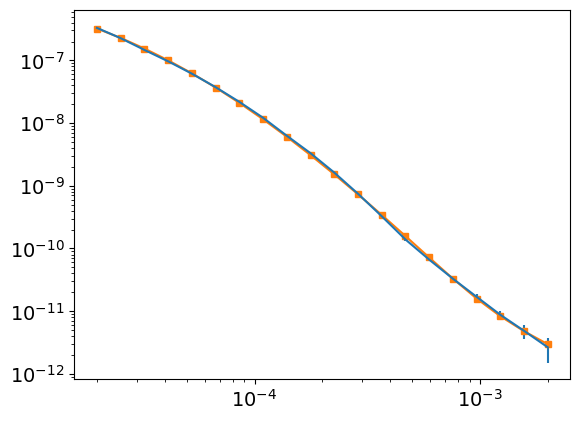

In [406]:

# plt.loglog(rx_times, -data_dict["background"][src, src.receiver_list[0]], "k", alpha=0.5)
# plt.loglog(rx_times, -data_dict[key][src, rx], "C0o", ms=4)
rx_times_invert = rx_times[:n_times_invert]
plt.errorbar(rx_times_invert, -inv.invProb.dmisfit[0][1].data.dobs, yerr=inv.invProb.dmisfit[0][1].data.standard_deviation)
plt.loglog(rx_times_invert, -inv.directiveList.dList[-2].outDict[iterations]["dpred"], "C1-s", ms=4)

(1e-05, 100.0)

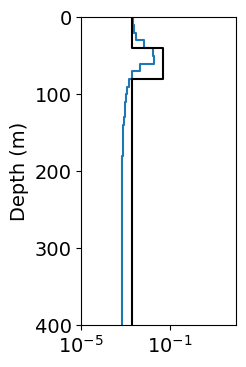

In [407]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
plot_1d_layer_model(
    thicknesses1d, np.exp(mopt), ax=ax, color="C0", label="recovered"
)
plot_1d_layer_model(
    thicknesses_true, sigma_true, ax=ax, color="k", label="true"
)
ax.set_ylim([400, 0])
ax.set_xlim([1e-5, 1e2])


In [438]:

ind = 0
source_sounding = full_survey.source_list[ind]
inv = create_inversion(
    ind, observed_data[source_sounding, source_sounding.receiver_list[0]], rx_times[:n_times_invert], rx_locs
)

In [439]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
mopt = inv.run(m0)



Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  5.98e+02  0.00e+00  5.98e+02    6.95e+02      0              
   1  1.33e+02  8.29e+01  5.80e-01  1.60e+02    7.83e+01      0              
   2  8.89e+01  4.53e+01  7.26e-01  1.10e+02    4.51e+01      0              
   3  5.93e+01  2.87e+01  8.66e-01  8.00e+01    3.11e+01      

(0.0001, 0.1)

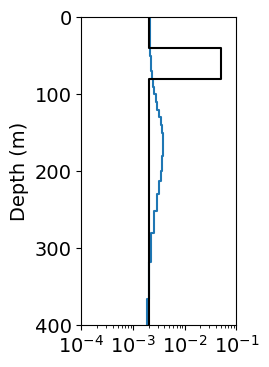

In [440]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
plot_1d_layer_model(
    thicknesses1d, np.exp(mopt), ax=ax, color="C0", label="recovered"
)
plot_1d_layer_model(
    thicknesses_true, sigma_true, ax=ax, color="k", label="true"
)
ax.set_ylim([400, 0])
ax.set_xlim([1e-4, 1e-1])


In [411]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)

In [434]:
directory = "/t40array/lheagy/2025-heagy-et-al-tle/dipping-layer-45"

In [435]:
def run_inv(ind, dobs, m0, directory=directory): 
    inv = create_inversion(ind, dobs)
    
    label_key=f"{ind}"
    
    mopt = inv.run(m0)
    np.save(f"{directory}/{label_key}_model.npy", mopt)
    
    inv_dict = inv.directiveList.dList[-2].outDict
    with open(f"{directory}/{label_key}_inv_dict.pkl", "wb") as f:
        pickle.dump(inv_dict, f)

    return label_key, mopt

In [436]:
ind=0
src = full_survey.source_list[ind]
rx = src.receiver_list[0]
run_inv(0, observed_data[src, rx], m0, directory)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  5.98e+02  0.00e+00  5.98e+02    6.95e+02      0              
   1  1.33e+02  8.29e+01  5.80e-01  1.60e+02    7.83e+01      0              
   2  8.89e+01  4.53e+01  7.26e-01  1.10e+02    4.51e+01      0              
   3  5.93e+01  2.87e+01  8.66e-01  8.00e+01    3.11e+01      

('0',
 array([-6.16097783, -6.15921032, -6.15391441, -6.14505027, -6.13180954,
        -6.11304198, -6.08727701, -6.05290065, -6.00853716, -5.95368105,
        -5.88944948, -5.81911285, -5.74801355, -5.68273565, -5.62976992,
        -5.59413279, -5.57838463, -5.58231798, -5.6032088 , -5.63636466,
        -5.68468439, -5.75894477, -5.85826161, -5.97394576, -6.09360613,
        -6.2051666 , -6.29957135, -6.37089916, -6.41500551, -6.42773227,
        -6.39601711, -6.23815469, -6.03312272]))

In [415]:
from joblib import Parallel, delayed
inv_dict = {}
results = Parallel(n_jobs=48, backend='loky')(  # 'loky' is the default and most flexible
    delayed(run_inv)(
        ind, observed_data[full_survey.source_list[ind], 
        full_survey.source_list[ind].receiver_list[0]], 
        m0, directory)
    for ind in range(rx_locs.shape[0])
)

# Collect results
for (label_key, mopt) in results:
    inv_dict[label_key] = mopt

In [441]:
def load_models_and_dicts(folder):
    inv_dicts = {}
    model_arrays = {}

    for fname in os.listdir(folder):
        full_path = os.path.join(folder, fname)

        if fname.endswith("_inv_dict.pkl"):
            key = fname.replace("_inv_dict.pkl", "")
            with open(full_path, "rb") as f:
                inv_dicts[key] = pickle.load(f)

        elif fname.endswith("_model.npy"):
            key = fname.replace("_model.npy", "")
            model_arrays[key] = np.load(full_path)

    return inv_dicts, model_arrays

In [442]:
inv_dicts, models_1d = load_models_and_dicts(directory)

In [443]:
mesh1d = discretize.TensorMesh([(np.r_[thicknesses1d, thicknesses1d[-1]])], origin="0")


In [444]:
mesh1d.cell_centers

array([   5.        ,   15.        ,   25.        ,   35.        ,
         45.        ,   55.        ,   65.        ,   75.        ,
         85.        ,   95.        ,  105.        ,  115.        ,
        125.        ,  135.        ,  145.        ,  155.        ,
        165.        ,  175.        ,  185.        ,  195.        ,
        206.5       ,  221.45      ,  240.885     ,  266.1505    ,
        298.99565   ,  341.694345  ,  397.2026485 ,  469.36344305,
        563.17247597,  685.12421875,  843.66148438, 1049.7599297 ,
       1282.74078092])

In [445]:
rx_x = np.unique(rx_locs[:, 0])
rx_y = np.unique(rx_locs[:, 1])

In [446]:
grid_1d_results = discretize.utils.ndgrid(
    rx_x, rx_y, -mesh1d.cell_centers
)

In [447]:
compiled_1d_models = np.zeros(len(grid_1d_results))

for key in models_1d.keys():
    ind = int(key)
    m = models_1d[key]
    sounding_inds = (
        (rx_locs[ind, 0] == grid_1d_results[:, 0]) & 
        (rx_locs[ind, 1] == grid_1d_results[:, 1])
    )
    compiled_1d_models[sounding_inds] = np.flipud(m)

In [448]:
hx = np.diff(rx_x)
hx = np.r_[hx, hx[-1]]
# hy = np.diff(rx_y)
# hy = np.r_[hy, hy[-1]]

mesh_results = discretize.TensorMesh(
    [hx, np.flipud(mesh1d.h[0])], origin="CN"
)

In [449]:
mesh_results

TensorMesh: 2,013 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     61       -305.00        305.00     10.00     10.00    1.00
   y     33     -1,399.23          0.00     10.00    232.98    1.30

In [450]:


target_x = np.r_[-200, 200]
target_y = np.r_[-400, 400]
target_z_center = -60
target_thickness = 40
target_zlim=np.r_[-200, -20]
target_z = target_z_center + target_thickness / 2 * np.r_[-1, 1]

dip = 45
target_x_center=-50
slope = np.tan(-dip*np.pi/180)

x_tmp = np.linspace(target_x.min(), target_x.max())

z_bottom = (x_tmp-target_x_center) * slope + target_z.min()
z_top = (x_tmp-target_x_center) * slope + target_z.max()

z_bottom[z_bottom < target_zlim.min()] = target_zlim.min()
z_bottom[z_bottom > target_zlim.max()] = target_zlim.max()
z_top[z_top > target_zlim.max()] = target_zlim.max()
z_top[z_top < target_zlim.min()] = target_zlim.min()

inds_equal = (z_top == z_bottom)
x_tmp = x_tmp[~inds_equal]
z_bottom = z_bottom[~inds_equal]
z_top = z_top[~inds_equal]

target_outline_x = np.hstack(
    [x_tmp, x_tmp[-1], np.flipud(x_tmp), x_tmp[0]]
)
target_outline_z = np.hstack(
    [z_bottom, z_bottom[-1], np.flipud(z_top), z_bottom[0]]
)


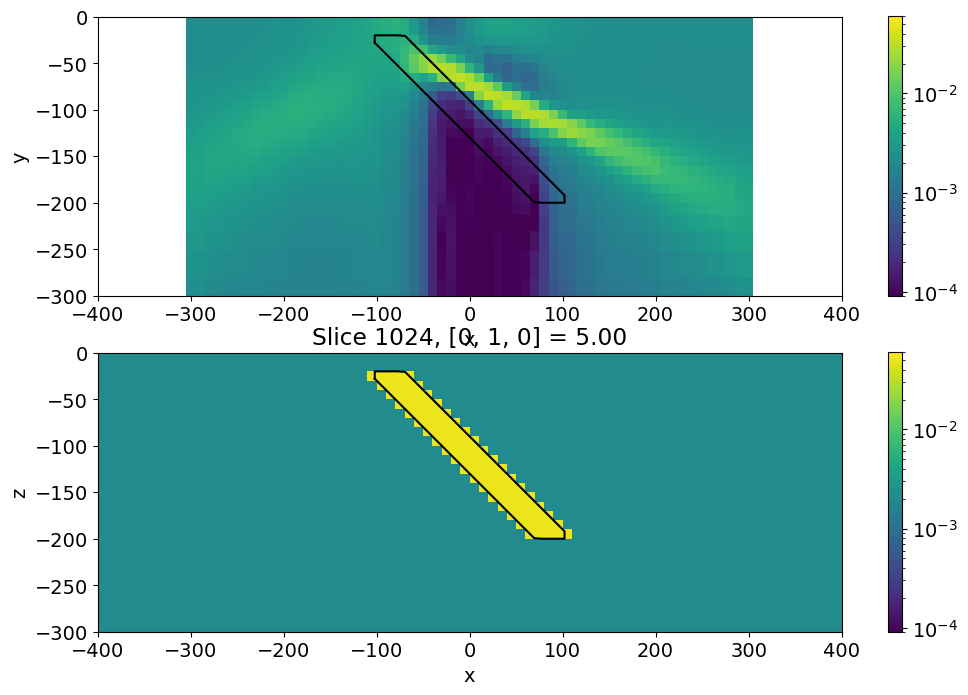

In [451]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

norm = LogNorm(vmin=9e-5, vmax=6e-2)
plt.colorbar(mesh_results.plot_image(
    np.exp(compiled_1d_models),
    # normal="Y", 
    pcolor_opts={"norm":norm},
    ax=ax[0],
    # ind=8
)[0], ax=ax[0])


plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax[1], pcolor_opts={"norm":norm}, 
        normal="Y",
    )[0], 
    ax=ax[1]
)


for a in ax.flatten():
    a.plot(target_outline_x, target_outline_z, color="k", lw=1.5)
    a.set_ylim(-300, 0)
    a.set_xlim(np.r_[-1, 1]*400)
    a.set_aspect(1)


In [452]:
dpred_1d = np.zeros((n_times_invert, len(rx_locs)))

for k in inv_dicts.keys():
    ind = int(k)
    
    idict = inv_dicts[k]
    iterations = len(idict)
    dpred_1d[:, ind] = idict[iterations]["dpred"]

    

In [453]:
dpred_1d = dpred_1d.reshape(n_times_invert, len(rx_x), len(rx_y), order="F")

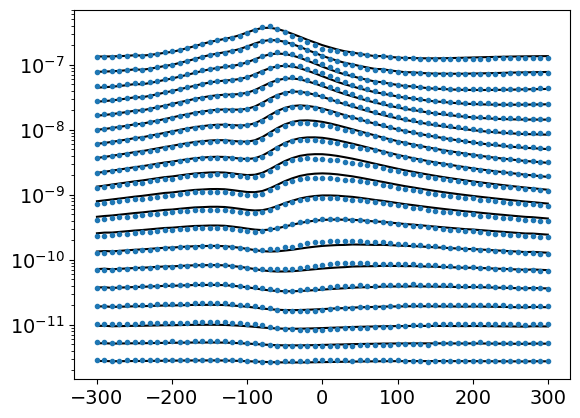

In [454]:
fig, ax = plt.subplots(1, 1)

line_number = 0

ax.semilogy(
    rx_x, -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :], 
    "k-", ms=3
);

ax.semilogy(rx_x, -dpred_1d[:, :, line_number].T, "C0o", ms=3);

In [455]:
mesh_results_3d=discretize.TensorMesh(
    [mesh_results.h[0], [(10,400)], mesh_results.h[1]], 
    origin = "CCN"
)

In [456]:
mapping_to_3d = maps.Surject2Dto3D(mesh_results_3d)

In [457]:
results3d = mapping_to_3d * compiled_1d_models

In [458]:
# # tmp = compiled_1d_models.reshape(mesh_results.shape_cells[0], mesh_results.shape_cells[1], order="F")
# results3d = np.zeros(mesh_results_3d.n_cells)
# for i in range(mesh_results_3d.shape_cells[1]):
#     inds = mesh_results_3d.cell_centers[:, 1] == mesh_results_3d.cell_centers_y[i]
#     results3d[inds] = compiled_1d_models



Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  5.84e+02  0.00e+00  5.84e+02    6.40e+02      0              
   1  1.33e+02  8.17e+01  6.10e-01  1.63e+02    7.45e+01      0              
   2  8.89e+01  4.19e+01  7.85e-01  1.12e+02    4.90e+01      0   Skip BFGS  
   3  5.93e+01  2.44e+01  9.30e-01  7.95e+01    3.28e+01      

In [ ]:
norm = LogNorm(vmin=3e-4, vmax=6e-2)
fig, ax = plt.subplots(1, 1)
mesh_results_3d.plot_slice(
    np.exp(results3d), 
    pcolor_opts={"norm":norm},
    normal="Y",
    ind=0,
    ax=ax
)


ax.set_ylim([-400, 0])


In [ ]:
P = discretize.utils.volume_average(mesh_results_3d, ubc_mesh)

In [ ]:
interpolated_model = P * results3d
interpolated_model[ubc_mesh.cell_centers[:, 2]>0] = np.log(1e-8)

In [ ]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(ubc_mesh.plot_slice(
    np.exp(interpolated_model),
    pcolor_opts = {"norm": LogNorm(3e-4, 1e-1)},
    ax=ax,
    normal="y"
)[0], ax=ax)

ax.set_xlim(np.r_[-1, 1]*500)
ax.set_ylim(np.r_[-500, 100])

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

pcolor_opts = {"norm":LogNorm(vmin=1e-4, vmax=3e-2), "cmap":"Spectral_r"}

plt.colorbar(
    ubc_mesh.plot_slice(
        np.exp(interpolated_model), ax=ax[0], pcolor_opts=pcolor_opts, 
        normal="y",
        # grid_opts={"color":"k","lw":0.5}
        # ind=1044
    )[0], ax=ax[0]
)
ax[0].plot(target_outline_x, target_outline_z, color="k")

plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax[1], pcolor_opts=pcolor_opts, 
        normal="y",
        grid_opts={"color":"k","lw":0.5}
        # ind=1044
    )[0], ax=ax[1]
)

for a in ax.flatten(): 
    a.set_xlim(500*np.r_[-1, 1])
    a.set_ylim(np.r_[-300, 60])
    a.plot(rx_locs[:, 0], rx_locs[:, 2], "wo", ms=4)
    a.set_aspect(1)

In [460]:
sim_directory_3d = "3D-sim-1d-results"

In [ ]:
discretize.TreeMesh.write_model_UBC(ubc_mesh, f"{sim_directory_3d}/model.con", np.exp(interpolated_model))

In [ ]:
# load and plot dpred, 1D inversion dpred, 3D simulation dpred

In [ ]:
dpred_from_3d = load_pre_file(f"{sim_directory_3d}/dpred0.txt")
dpred_values = np.zeros((n_times_invert, len(dobs["transmitters"])))

for i in range(len(dpred_from_3d["transmitters"])): 
    for j in range(n_times_invert): 
        dpred_values[j, i] = dpred_from_3d["transmitters"][i]["receivers"][j]["data"][-1]

In [ ]:
dpred_values = dpred_values.reshape(n_times_invert, len(rx_x), len(rx_y), order="F")

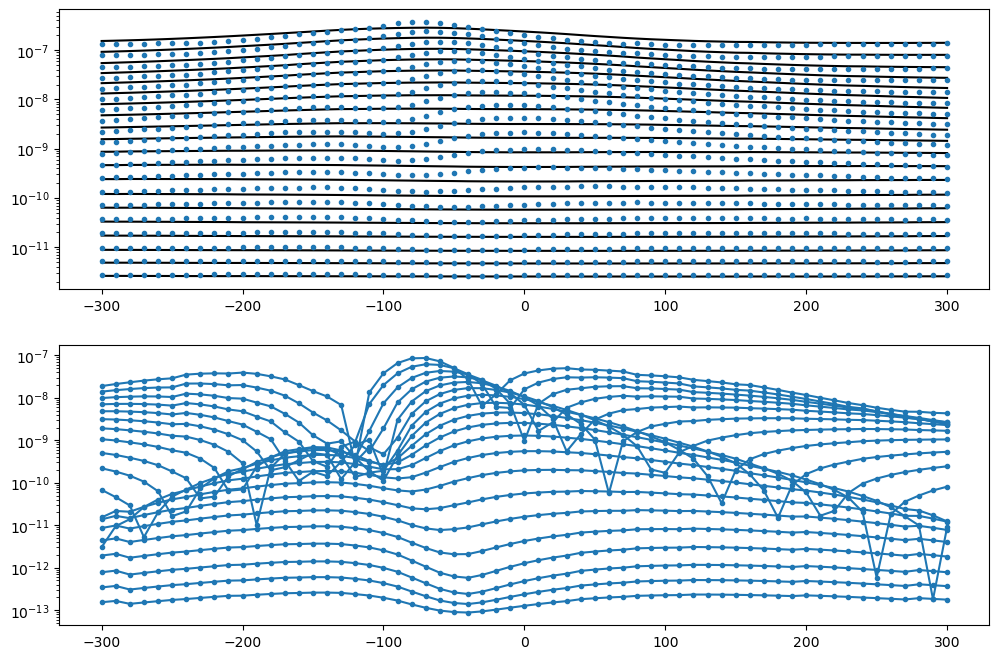

In [260]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

line_number = 0

ax[0].semilogy(rx_x, dpred_values[:, :, line_number].T, "k");

true_data = -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :]
ax[0].semilogy(
    rx_x, true_data, 
    "C0o", ms=3
);



ax[1].semilogy(
    rx_x, np.abs(true_data-dpred_values[:, :, line_number].T),
    "C0-o", ms=3
);



In [261]:
# fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# line_number = 4

# true_data = -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :]
# ax[0].semilogy(
#     rx_x, true_data, 
#     "ko", ms=3
# );

# ax[0].semilogy(rx_x, -dpred_1d[:, :, line_number].T, "C1-");


# ax[1].semilogy(
#     rx_x, np.abs(true_data+dpred_1d[:, :, line_number].T),
#     "C1-o", ms=3
# );



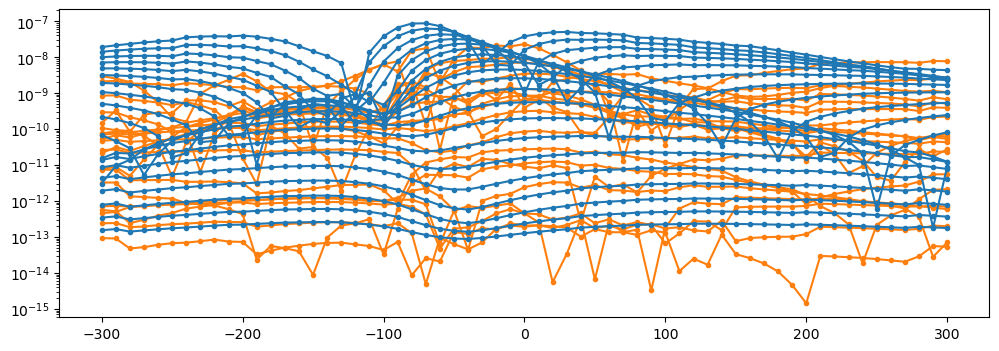

In [262]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.semilogy(
    rx_x, np.abs(true_data+dpred_1d[:, :, line_number].T),
    "C1-o", ms=3
);

ax.semilogy(
    rx_x, np.abs(true_data-dpred_values[:, :, line_number].T),
    "C0-o", ms=3
);

In [ ]:
len(rx_locs)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

src_ind = 30
source_sounding = source_list[src_ind]

plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax[0], pcolor_opts={"norm":pcolor_opts},
        normal="Y"
        # normal="Z", ind=2937
    )[0], 
    ax=ax[0]
)

ax[0].set_xlim(500*np.r_[-1, 1])
ax[0].set_ylim(np.r_[-400, 40])
ax[0].set_aspect(1)

ax[0].plot(rx_locs[:, 0], rx_locs[:, 1], "wo", ms=4)
ax[0].plot(rx_locs[src_ind, 0], rx_locs[src_ind, 1], "rs", ms=6)


# ax[1].loglog(rx_times, -dpred_halfspace, "k-", ms=4, label="halfspace", alpha=0.2)
ax[1].loglog(rx_times, -observed_data[source_sounding, source_sounding.receiver_list[0]], "C0o", ms=6, label="dobs")
ax[1].loglog(rx_times, -dpred_1d.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind], "C1-", label="dpred 1D inv")
ax[1].loglog(rx_times, dpred_values.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind], "C2-", label="dpred 3D fwd")
ax[1].grid()
ax[1].legend()

true = -observed_data[source_sounding, source_sounding.receiver_list[0]]
# ax[2].loglog(rx_times, , "C0o", ms=6, label="dobs")
ax[2].loglog(rx_times, np.abs(true + dpred_1d.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind]), "C1-", label="dpred 1D inv")
ax[2].loglog(rx_times, np.abs(true-dpred_values.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind]), "C2-", label="dpred 3D fwd")
ax[2].grid()
ax[2].legend()

for a in ax[1:].flatten():
    a.set_ylim([1e-12, 1e-6])

# ax.legend()

In [ ]:
dpred_1d.reshape(20, len(rx_x)*len(rx_y), order="F")[:, src_ind]

# make figures

In [265]:
mrec3d = discretize.TreeMesh.read_model_UBC(ubc_mesh, "inv.con")

In [264]:
dinv3d = np.loadtxt("dpred.txt")[:, -1].reshape(20, len(rx_locs), order="F")

Text(0.5, 0, 'x (m)')

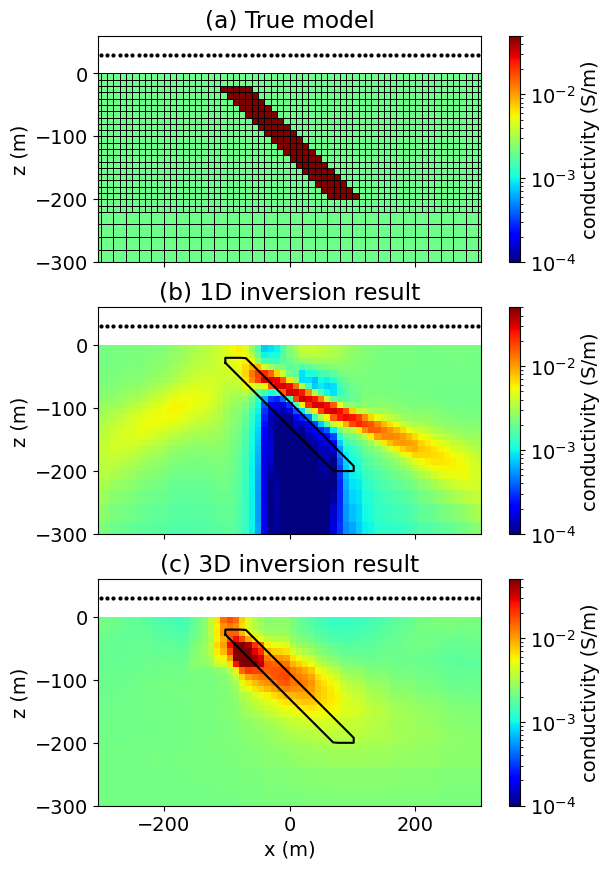

In [463]:
fig, ax = plt.subplots(3, 1, figsize=(7, 10), sharex=True)


pcolor_opts = {"norm":LogNorm(vmin=1e-4, vmax=1/20), "cmap":"jet"}

model_plot = model.copy()
model_plot[model_plot == 1e-8] = np.nan
cb = plt.colorbar(
    ubc_mesh.plot_slice(
        model_plot, ax=ax[0], pcolor_opts=pcolor_opts, 
        normal="y",
        grid_opts={"color":"k","lw":0.5}
        # ind=1044
    )[0], ax=ax[0]
)
cb.set_label("conductivity (S/m)")

cb = plt.colorbar(mesh_results.plot_image(
    np.exp(compiled_1d_models),
    # normal="Y", 
    pcolor_opts=pcolor_opts,
    ax=ax[1],
    # ind=8
)[0], ax=ax[1])
cb.set_label("conductivity (S/m)")

mrec3d_plot = mrec3d.copy()
mrec3d_plot[mrec3d_plot == 1e-8] = np.nan
cb = plt.colorbar(
    ubc_mesh.plot_slice(
        mrec3d_plot, ax=ax[2], pcolor_opts=pcolor_opts, 
        normal="y",
        # grid_opts={"color":"k","lw":0.5}
        # ind=1044
    )[0], ax=ax[2],
)
cb.set_label("conductivity (S/m)")

ax[0].set_title("(a) True model")
ax[1].set_title("(b) 1D inversion result")
ax[2].set_title("(c) 3D inversion result")

for a in ax[1:]:
    a.plot(target_outline_x, target_outline_z, color="k")




for a in ax.flatten(): 
    a.set_xlim(305*np.r_[-1, 1])
    a.set_ylim(np.r_[-300, 60])
    a.plot(rx_locs[:, 0], rx_locs[:, 2], "ko", ms=2)
    a.set_aspect(1)
    a.set_xlabel("")
    a.set_ylabel("z (m)")

ax[2].set_xlabel("x (m)")

In [465]:
target_outline_x.max()

np.float64(102.0408163265306)

In [307]:
from matplotlib import rcParams
rcParams["font.size"] = 16

Text(0.5, 0, 'x (m)')

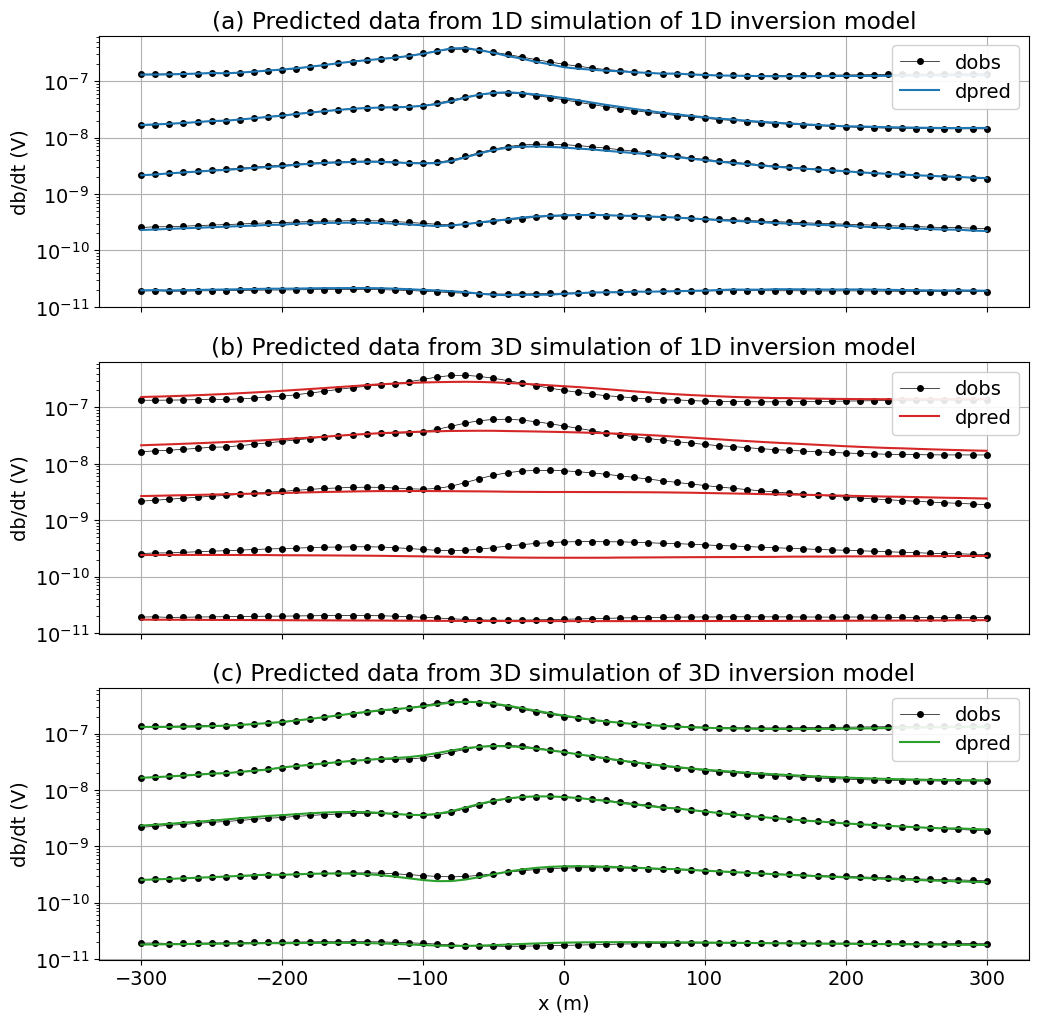

In [469]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=True)

dt = 4 # downsample in time (show every second time channel)
line_number = 0

for a in ax:
    a.semilogy(
        rx_x, true_data[:, ::dt], 
        "ko-", ms=4, lw=0.5
    );
    a.grid()
    a.plot([np.nan], [np.nan], "ko-", label="dobs", ms=4, lw=0.5)
    
ax[0].semilogy(rx_x, -dpred_1d[::dt, :, line_number].T, "C0", lw=1.5)
ax[0].plot([np.nan], [np.nan], "C0", label="dpred")
ax[0].set_title("(a) Predicted data from 1D simulation of 1D inversion model")

ax[1].semilogy(rx_x, dpred_values[::dt, :, line_number].T, "C3", lw=1.5);
ax[1].set_title("(b) Predicted data from 3D simulation of 1D inversion model")
ax[1].plot([np.nan], [np.nan], "C3", label="dpred")

ax[2].semilogy(rx_x, dinv3d[::dt, :].T, "C2", lw=1.5);
ax[2].set_title("(c) Predicted data from 3D simulation of 3D inversion model")
ax[2].plot([np.nan], [np.nan], "C2", label="dpred")

for a in ax: 
    a.set_ylabel("db/dt (V)")
    a.legend(loc=1, framealpha=0.9)
# true_data = -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :]
ax[2].set_xlabel("x (m)")

In [346]:

rcParams["font.size"] = 14

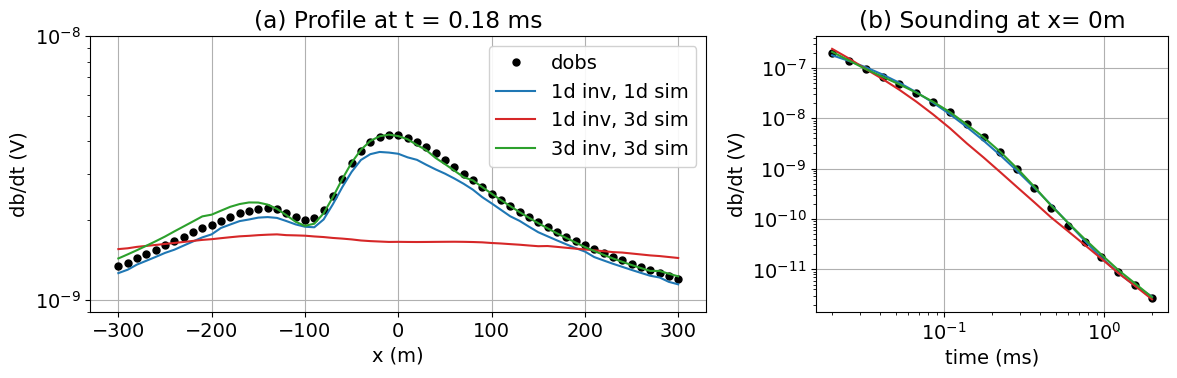

In [468]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [1.75, 1]})

time_ind = 9  # 10th time channel 
sounding_ind = 30

ax[0].semilogy(rx_x, true_data[:, time_ind], "ko", ms=5, lw=0.0, label="dobs"); 
ax[0].semilogy(rx_x, -dpred_1d[time_ind, :, line_number].T, "C0", lw=1.5, label="1d inv, 1d sim")
ax[0].semilogy(rx_x, dpred_values[time_ind, :, line_number].T, "C3", lw=1.5, label="1d inv, 3d sim");
ax[0].semilogy(rx_x, dinv3d[time_ind, :].T, "C2", lw=1.5, label="3d inv, 3d sim");
ax[0].set_ylim(9e-10, 1e-8)

ax[1].loglog(rx_times*1e3, true_data[sounding_ind, :], "ko", ms=5, lw=0.0, label="dobs"); 
ax[1].loglog(rx_times*1e3, -dpred_1d[:, sounding_ind, line_number].T, "C0", lw=1.5, label="1d inv, 1d sim")
ax[1].loglog(rx_times*1e3, dpred_values[:, sounding_ind, line_number].T, "C3", lw=1.5, label="1d inv, 3d sim");
ax[1].loglog(rx_times*1e3, dinv3d[:, sounding_ind].T, "C2", lw=1.5, label="3d inv, 3d sim");

ax[0].legend(loc=0, framealpha=0.9)

for a in ax: 
    a.set_ylabel("db/dt (V)")
    a.grid("both")
# true_data = -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :]

ax[0].set_title(f"(a) Profile at t = {rx_times[time_ind]*1e3:1.2f} ms")
ax[1].set_title(f"(b) Sounding at x= {rx_x[sounding_ind]:1.0f}m")

ax[0].set_xlabel("x (m)")
ax[1].set_xlabel("time (ms)")
plt.tight_layout()

In [467]:
np.atan((130-70)/100)*180/np.pi

np.float64(30.96375653207352)